## Model of Lupus Nephritis

This is the main code document for recapitulation of parameters in our report. 

Further code and supporting information can be found at [github.com/pascoesean/lupus-model](https://github.com/pascoesean/lupus-model)

Also see the original paper: [here](https://tbiomed.biomedcentral.com/articles/10.1186/1742-4682-7-14)

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.integrate import odeint
rng = np.random.default_rng()

### Refit model


First, we refit the model from the original publication with piecewise parameters

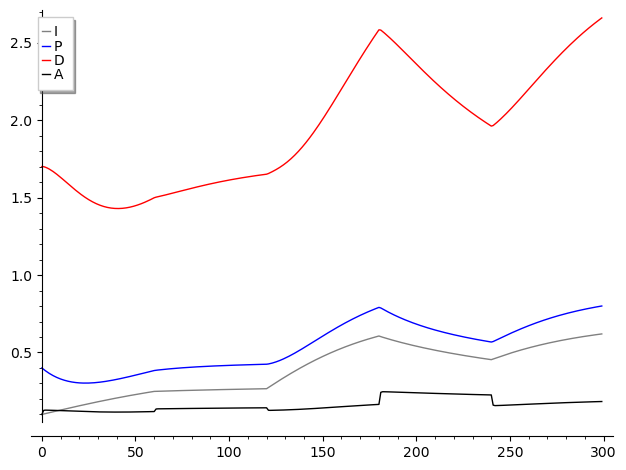

In [3]:
# Define Variables and parameters

init = (0.1, 0.4, 1.7, 0.1)

(si, sid, kid, kip, kpi, kpp, kpd, mup, 
 kdip, kdp, mud, sa, kap, kad, mua, Ainf) = (0.002, 0.015, 1, 0.025, 0.13, 0.02, 0.001, 0.06, 
                                               0.025, 0.27, 0.04, 0.05, 0.022, 0.22, 2.2, 0.45)

tmax=300
t_range = srange(0, tmax, 1)

# Helper functions
def sa_func(t):
    saf = 3*sa
    return saf if t >=changeday and t<=200 else sa

def fsid_t(t): #time dependency Sid
    sid = 0.005
    if 0 <= t <= 60: 
        sid = 0.005 # 6m-4m
    elif 60 < t <= 120:
        sid = 0.003 # 4m-2m
    elif 120 < t <= 165:
        sid = 0.015 # 2m-2w
    elif 165 < t <= 180:
        sid = 0.015 # 2w-flare
    elif 180 < t <= 195:
        sid = 0.002 # flare-2w
    elif 195 < t <= 225:
        sid = 0.002 # 2w-6w
    elif 225 < t <= 240:
        sid = 0.002 # 6w-2m
    else:
        sid = 0.012 #2m-4m
    return sid 

def fsi_t(t): #time dependency Si
    si = 0.002
    if 0 <= t <= 60: 
        si = 0.002
    elif 60 < t <= 120:
        si = 0.001
    elif 120 < t <= 165:
        si = 0.005
    elif 165 < t <= 180:
        si = 0.005
    elif 180 < t <= 195:
        si = 0.001
    elif 195 < t <= 225:
        si = 0.001
    elif 225 < t <= 240:
        si = 0.001
    else:
        si = 0.005
    return si 

def fsa_t(t): #time dependency Sa
    sa = 0.05
    if 0 <= t <= 60: 
        sa = 0.05
    elif 60 < t <= 120:
        sa = 0.1
    elif 120 < t <= 165:
        sa = 0.05
    elif 165 < t <= 180:
        sa = 0.05
    elif 180 < t <= 195:
        sa = 0.3
    elif 195 < t <= 225:
        sa = 0.3
    elif 225 < t <= 240:
        sa = 0.3
    else:
        sa = 0.1
    return sa 

# Diff Eq's and system
def plot_ts4(LupusSim, times=t_range):
    LupusSim = np.insert(LupusSim, 0, times, axis=1)
    Its = list_plot(LupusSim[::,(0,1)], plotjoined=True, color="grey", legend_label="I")
    Pts = list_plot(LupusSim[::,(0,2)], plotjoined=True, color="blue", legend_label="P")
    Dts = list_plot(LupusSim[::,(0,3)], plotjoined=True, color="red", legend_label="D")
    Ats = list_plot(LupusSim[::,(0,4)], plotjoined=True, color="black", legend_label="A")
    return Its+Pts+Dts+Ats

def LupusSys(IPDA, t, si_t, 
             sid_t, kid_t, kip_t, kpi_t, kpp_t, kpd_t, mup_t, 
             kdip_t, kdp_t, mud_t, sa_t, kap_t, kad_t, mua_t, Ainf_t):
    I, P, D, A = IPDA
    def f(x):
        return x/((1+A/Ainf_t)^2)
    Idot = f(si_t(t)) + f(sid_t(t))*(D^2/(kid_t^2 + D^2)) - kip_t*f(P)*I
    Pdot = f(kpi_t*I + kpp_t*P) + f(kpd_t*D) - mup_t*P 
    Ddot = kdip_t*f(P)*I + kdp_t*f(P) - mud_t*D 
    Adot = sa_t(t) + f(kap_t*P + kad_t*D) - mua_t*A 
    LupusSystem = (Idot, Pdot, Ddot, Adot)
    return LupusSystem
       
# Simulation
LupusSim = odeint(LupusSys, init, t_range, args = (fsi_t, fsid_t, kid, kip, kpi, kpp, kpd, mup, kdip, kdp, mud, fsa_t, kap, kad, mua, Ainf))
show(plot_ts4(LupusSim))

In [ ]:
Next, we demonstrate modulating different parameters

In [ ]:
def generate_ts_params(tmax = 600, flare_odds = 0.05, flare_length = 5, si_0 = 0.002, sid_0 = 0.015, sa_0 = 0.2):
    
    # set some values to keep track of if we are on a flare
    flare_ts = []
    flare_tracker = False
    flare_day = 0
    for i in range(tmax):
        event = rng.binomial(n = 1, p = flare_odds)
        if event == 1:
            flare_tracker = True
        if (flare_tracker) & (flare_day < flare_length):
            flare_ts.append("flare")
            flare_day += 1
        else:
            flare_ts.append("no flare")
        if flare_day == flare_length:
            flare_tracker = False
            flare_day = 0

    by_time_params = pd.DataFrame(srange(0, tmax, 1), columns = ["time"], dtype = "float")

    by_time_params['flare_status'] = np.array(flare_ts)
    
    by_time_params['si'] = by_time_params['time'].apply(fsi_t)
    by_time_params['si'] = np.where(by_time_params['flare_status'] == "flare",
                                by_time_params['si']*5,
                                by_time_params['si'])
    
    by_time_params['sid'] = by_time_params['time'].apply(fsid_t)
    by_time_params['sid'] = np.where(by_time_params['flare_status'] == "flare",
                                by_time_params['sid']*5,
                                by_time_params['sid'])
    
    by_time_params['sa'] = by_time_params['time'].apply(fsa_t)
    by_time_params['sa'] = np.where(by_time_params['flare_status'] == "flare",
                                by_time_params['sa']/4,
                                by_time_params['sa'])
    return by_time_params

def lupus_flare_tsinput(by_time_params = generate_ts_params(tmax = 600),
                         init = (0.1, 0.4, 1.7, 0.1), # tuple: (I0, P0, D0, A0)
                         tmax=600, # number of days to simulate # num of days a flare lasts
                         kid = 1,
                         kip = 0.025, #rate of immune complex removal from system
                         kpi = 0.13, #rate of mediator activation and recruitment
                         kpp = 0.02, #immune response amplified by existing inflammatory response (kpi)
                         kpd = 0.001, #rate of activation for pro-inflammatory agents as a result of cytokine release or induced by damaged tissue
                         mup = 0.06, #decay of pro-inflammatory mediators
                         kdip = 0.025, #rate of phagocytosis of immune complexes by immune cells
                         kdp = 0.27, #rate at which collateral damage is produced by pro-inflammatory mediators 
                         mud = 0.04, #decay rate of damage
                         #sa = 0., #addition of anti-inflammatory drugs
                         kap = 0.022, #intrarenal production of anti-inflammatory mediators
                         kad = 0.22, #intrarenal rate of tissue damage ??
                         mua = 2.2, #rate of anti-inflammatory agent degradation
                         Ainf = 1
                        ):

    Lupusvars = list(var("I", "P", "D", "A"))
    t_range = srange(0, tmax, 1)

    def fsid_t(t): #time dependency Sid
        integer = round(t)
        return by_time_params.to_dict(orient = "index").get(integer).get("sid")

    def fsi_t(t): #time dependency Si
        integer = round(t)
        return by_time_params.to_dict(orient = "index").get(integer).get("si")

    def fsa_t(t): #time dependency Sa
        integer = round(t)
        return by_time_params.to_dict(orient = "index").get(integer).get("sa")


    def systems (IPDA, t, si_t,sid_t,sa_t):
        I, P, D, A = IPDA 
        def f(x):
            return x/((1+A/Ainf)^2) 

        Idot = f(si_t(t)) + f(sid_t(t))*(D^2/(kid^2 + D^2)) - kip*f(P)*I
        Pdot = f(kpi*I + kpp*P) + f(kpd*D) - mup*P
        Ddot = kdip*f(P)*I + kdp*f(P) - mud*D
        Adot = sa_t(t) + f(kap*P + kad*D) - mua*A

        LupusSystem = (Idot, Pdot, Ddot, Adot)
        return LupusSystem

    IPDAsim = odeint(systems, init, t_range, args=(fsi_t, fsid_t, fsa_t))
    IPDAsim = np.insert(IPDAsim, 0, t_range, axis=1)

    return IPDAsim

def plot_ts4(sim, title = ""):
    Its = list_plot(sim[::,(0,1)], plotjoined=True, color="grey", legend_label="I")
    Pts = list_plot(sim[::,(0,2)], plotjoined=True, color="blue", legend_label="P")
    Dts = list_plot(sim[::,(0,3)], plotjoined=True, color="red", legend_label="D")
    Ats = list_plot(sim[::,(0,4)], plotjoined=True, color="purple", legend_label="A", title = title)
    return Its+Pts+Dts+Ats

plot_ts4(lupus_flare_tsinput(), title = "Lupus Stochastic")